In [1]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')

# 고객 행동 예측

### 1 : 데이터 읽고 확인

In [2]:
import pandas as pd

uselog = pd.read_csv('./data/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
customer = pd.read_csv('./data/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### 2 : 클러스터링으로 회원 그룹화

In [4]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# mean, median, max, min : 월 이용 횟수, 1~8
# membership_period : 기간, 최댓값(47)
# 표준화 : StandardScaler()
sc = StandardScaler() # 표준화
customer_clustering_sc = sc.fit_transform(customer_clustering)

# 필드 추출, K-means 알고리즘 사용(클러스터 개수 : 4개 그룹)
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)

customer_clustering["cluster"] = clusters.labels_ # 0~3까지 
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 2 0 1]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


### 3 : 클러스터링 결과 분석

In [6]:
customer_clustering.columns = ["월평균값","월중앙값", "월최댓값", "월최솟값","회원기간", "cluster"]
customer_clustering.groupby("cluster").count()
# 그룹 0이 고객이 가장 많음 > 그룹2 > 그룹1 > 그룹3

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,846,846,846,846,846
2,763,763,763,763,763
3,1249,1249,1249,1249,1249


In [7]:
# 그룹별 평균값 출력
customer_clustering.groupby("cluster").mean()

# 그룹0는 회원 기간이 짧지만, 이용률이 높은 회원임 
# 그룹별 특징을 파악하고 그룹별로 다른 캠페인 마케팅을 해볼 수 있음

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,3.054713,2.888598,4.756225,1.653997,9.263434
3,4.677494,4.671337,7.232986,2.153723,36.915933


### 4 : 클러스터링 결과 가시화

In [8]:
# 주성분 분석 
from sklearn.decomposition import PCA

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]


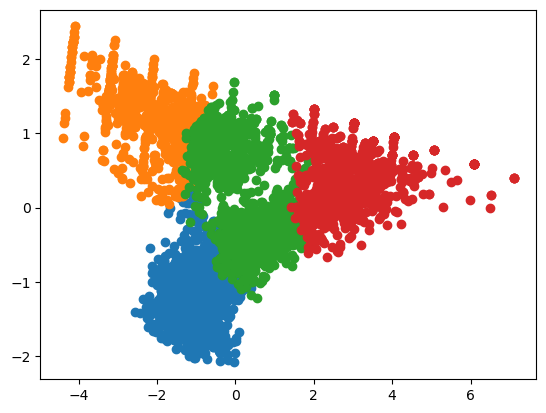

In [9]:
import matplotlib.pyplot as plt

for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

### 5 : 클러스터링 결과를 바탕으로 탈퇴회원 경향 파악

In [10]:
# 4개의 그룹에서 지속 회원과 탈퇴 회원이 얼마나 있을까?
# 지속회원과 탈퇴 회원을 집계 : is_deleted열
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

# 그룹0, 1이 지속회원이 많음
# 그룹2는 탈퇴회원만 있음, 그룹3은 골고루 포함되어 있음

# 그룹0은 회원기간은 짧지만 의욕적이어서 전체 이용률이 높음
# 그룹1은 그룹0보다는 이용률이 많지는 않지만, 회원기간이 기간이 길고 지속회원이 많은걸 고려해 보면 안정적인 그룹임

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,0,827
3,1,1,19
4,2,1,763
5,3,0,1230
6,3,1,19


In [11]:
# 정기적/비정기적 이용 여부 : routine_flg 사용
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

# 결과 : 지속회원이 많은 그룹 0, 1번이 정기적으로 이용하는 회원이 많다는 것을 확인

,cluster,routine_flg,customer_id
0,0,0,228
1,0,1,1106
2,1,0,52
3,1,1,794
4,2,0,497
5,2,1,266
6,3,0,2
7,3,1,1247


### 6 : 다음달의 이용횟수 예측을 위해 테이터 준비
* 6개월의 이용 데이터를 사용해 다음달 이용 횟수를 예측

In [12]:
# 가정 : 이번달 2018년 10월, 2018년 11월 이용 횟수를 예측
# 2108년 5~10월(6개월) 이용 데이터 + 2018년 11월의 이용 횟수를 정답 데이터를 학습에 사용

# uselog을 사용, 연월/회원마다 집계
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [13]:
year_months = list(uselog_months["연월"].unique())
year_months

['201804',
 '201805',
 '201806',
 '201807',
 '201808',
 '201809',
 '201810',
 '201811',
 '201812',
 '201901',
 '201902',
 '201903']

In [14]:
uselog_months

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [15]:
# 이번달 부터 과거 6개월분의 이용 횟수, 다음달의 이용횟수를 저장
# 대상 : 2018년10월 ~ 2019년3월(반년)
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]]  
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)    
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [16]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### 7 : 특징이 되는 변수 추가

In [17]:
# 회원 기간을 추가 : 시계열 변화를 볼 수 있음
# 고객 데이터 customer->start_date 칼럼을 predict_data에 결합
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]], on="customer_id", how="left")
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [22]:
year_months[0] + '01'
predict_data['now'] = pd.to_datetime(predict_data['연월'] + '01')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

from dateutil.relativedelta import relativedelta

predict_data['membership_period'] = 0

for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now'].iloc[i], predict_data['start_date'].iloc[i])
    print(delta, delta.months)
    predict_data['membership_period'].iloc[i] = delta.years*12 + delta.months
    
predict_data.head()
predict_data.fillna(0,inplace=True)
predict_data.info()    

relativedelta(years=+1, months=+11) 11
relativedelta(years=+2, months=+11) 11
relativedelta(years=+3, months=+3) 3
relativedelta(years=+1, months=+4) 4
relativedelta(years=+1) 0
relativedelta(years=+2) 0
relativedelta(years=+1, months=+10) 10
relativedelta(years=+2, months=+5) 5
relativedelta(years=+3) 0
relativedelta(years=+1, months=+5) 5
relativedelta(years=+2, months=+2) 2
relativedelta(months=+7) 7
relativedelta(months=+9) 9
relativedelta(years=+2, months=+2) 2
relativedelta(years=+3, months=+5) 5
relativedelta(years=+1, months=+4) 4
relativedelta(years=+3, months=+3) 3
relativedelta(years=+3, months=+5) 5
relativedelta(months=+11) 11
relativedelta(years=+1, months=+7) 7
relativedelta(months=+11) 11
relativedelta(years=+2, months=+1) 1
relativedelta(years=+2, months=+9) 9
relativedelta(months=+9) 9
relativedelta(years=+3, months=+2) 2
relativedelta(years=+1, months=+8) 8
relativedelta(years=+3, months=+4) 4
relativedelta(years=+3, months=+4) 4
relativedelta(years=+3) 0
relativedel

### 8 : 다음달 이용횟수를 예측하는 모델 구축

In [23]:
from sklearn import linear_model
import sklearn.model_selection

model = linear_model.LinearRegression()

predict_data = predict_data.loc[predict_data['start_date'] > pd.to_datetime('20180401')]
y = predict_data['count_pred']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [4192, 1668]

In [ ]:
print(model.score(X_train, y_train))
print(model.score(X_test,y_test))

### 9 : 모델에 기여하는 변수 확인

### 10: 다음달의 이용횟수 예측